# **Descarga de imagenes Sentinel-2 mediante GEE a través de geojson que representa una ROI**

El presente notebook cumple con el objetivo 1 del proyecto, el cual se basa en obtener sistematicamente las imagenes multiespetrales de la región de interes (cultivo de arroz) a traves de los archivos geojson que las define.

Para cada geojson que es el area cultivada de arroz de un municipio y una ventana temporal (ambos datos rastreables en el nombre del archivo) se obtiene una gráfica del NDVI, NDWI y los porcentajes de nubosidad para detectar la etapa reproductiva (e2) y en función de ella asignar fechas de las etapas vegetativas (e1) y maduración (e3).

Una vez identificadas estas ventanas temporales, se pretende obtener una imagen con el menor porcentaje de nubosidad disponible, dicha imagen contara con la siguiente caracteristica:



1.   Bandas R, G, B, NIR normalizadas y canal adicional computo del NDVI.
2.   Resolución de 10m por pixel.
3.   Pixeles fuera de la región de interes nulos.
4.   Nombre del archivo identificable en: zafra_municipio_etapa_fecha.tif

**Proceso:**



1.   Conectarse a GEE y Google Drive.
2.   Disponer de todos los geojson en una carpeta unica.
3.   Por cada geojson se generan un directorio con los siguientes archivos;
una imagen tif para cada etapa, un csv con la linea temporal y un png de la gráfica.





### **Instalar e importar todas las librerias y modulos necesarios**

In [ ]:
# Instalar bibliotecas necesarias
!pip install earthengine-api geemap geopandas matplotlib rasterio
!pip install requests

# Importar módulos
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import timedelta
import requests
from datetime import datetime
from google.colab import drive
import csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00


### **Definición de métodos utilitarios**

In [ ]:
def proccess_geojson(geojson_path, min_area_ha=None, max_area_ha=None):
    """
    Procesa un archivo GeoJSON para preparar la geometría y los parámetros de descarga de imágenes satelitales.

    Esta función lee un archivo GeoJSON, convierte su geometría a un objeto compatible con Google Earth Engine (GEE),
    calcula el área en hectáreas, y determina las fechas de período agrícola a partir del nombre del archivo.
    También evalúa si el polígono cumple con límites de área mínimos y/o máximos y crea el directorio de salida
    donde se guardarán las descargas.

    Parámetros
    ----------
    geojson_path : str
        Ruta absoluta o relativa del archivo .geojson a procesar.
    min_area_ha : float, opcional
        Límite inferior de área en hectáreas. Si el área del polígono es menor o igual, el archivo se ignora.
    max_area_ha : float, opcional
        Límite superior de área en hectáreas. Si el área del polígono es mayor o igual, el archivo se ignora.

    Retorna
    -------
    tuple
        (geometry, start_date, end_date, scale, max_cloud, drive_download_dir, geo_filename, bounds)

        Donde:
        - geometry (ee.Geometry): Geometría convertida a formato de Earth Engine.
        - start_date (str): Fecha de inicio del período, derivada del nombre del archivo (formato 'YYYY-MM-DD').
        - end_date (str): Fecha de fin del período, derivada del nombre del archivo.
        - scale (int): Resolución espacial en metros utilizada para la descarga (predeterminado 10 m).
        - max_cloud (int): Porcentaje máximo de nubosidad permitido (predeterminado 100).
        - drive_download_dir (str): Ruta de la carpeta donde se guardarán las descargas.
        - geo_filename (str): Nombre base del archivo GeoJSON (sin extensión).
        - bounds (ee.Geometry.BoundingBox): Límites de la geometría en coordenadas de Earth Engine.

    Retorna None en todos los campos si la geometría no cumple con los criterios de área especificados.

    Ejemplo
    -------
    >>> proccess_geojson('2223_region.geojson', min_area_ha=5, max_area_ha=50)
    Posible tamaño a 10m: (256, 256)
    Posible tamaño a 20m: (128, 128)
    (ee.Geometry(...), '2022-09-01', '2023-06-30', 10, 100, './2223_region', '2223_region', ...)
    """

    geo_filename = os.path.basename(geojson_path).replace('.geojson', '')
    period = geo_filename.split('_')[0]
    y_1 = period[:2]
    y_2 = period[2:]
    gdf = gpd.read_file(geojson_path)

    # Convertir a geometría de GEE
    geometry = geemap.geopandas_to_ee(gdf)
    bounds = geometry.geometry().bounds()
    print('Posible tamaño a 10m:', get_size_pixels(bounds, 10))
    print('Posible tamaño a 20m:', get_size_pixels(bounds, 20))

    area_ha = geometry.geometry().area().getInfo() / 10000

    if min_area_ha and area_ha <= min_area_ha:
        print(f"Ignorando {geo_filename}.geojson porque es menor a {min_area_ha} ha")
        return None, None, None, None, None, None, None, None

    if max_area_ha and area_ha >= max_area_ha:
        print(f"Ignorando {geo_filename}.geojson porque es mayor a {max_area_ha} ha")
        return None, None, None, None, None, None, None, None

    # Construcción de argumentos
    start_date = f'20{y_1}-09-01'
    end_date = f'20{y_2}-06-30'
    scale = 10
    max_cloud = 100
    drive_download_dir_root = os.path.dirname(geojson_path)
    drive_download_dir = os.path.join(drive_download_dir_root, geo_filename)

    # Crear la carpeta de destino
    os.makedirs(drive_download_dir, exist_ok=True)
    return geometry, start_date, end_date, scale, max_cloud, drive_download_dir, geo_filename, bounds

def get_size(bounds):
    """
    Recibe un objeto ee.Geometry.Polygon rectangular y devuelve el largo y ancho en metros.

    Args:
        bounds (ee.Geometry.Polygon): Polígono rectangular (4 vértices, cerrado).

    Returns:
        tuple: (largo_metros, ancho_metros) flotantes con las dimensiones del rectángulo.
    """
    vertices = bounds.coordinates().getInfo()[0]

    p_sw = ee.Geometry.Point(vertices[0])
    p_nw = ee.Geometry.Point(vertices[1])
    p_se = ee.Geometry.Point(vertices[3])

    largo = p_sw.distance(p_nw)  # Distancia vertical en metros
    ancho = p_sw.distance(p_se)  # Distancia horizontal en metros

    # Obtener valores numéricos (ya es float)
    largo_val = largo
    ancho_val = ancho

    return largo_val.getInfo(), ancho_val.getInfo()


def get_size_pixels(bounds, resolution):
    """
    Recibe un objeto ee.Geometry.Polygon rectangular y una resolución espacial (m / pixel).
    Devuelve el tamaño aproximado en píxeles (ancho y alto) según esa resolución.

    Args:
        bounds (ee.Geometry.Polygon): Polígono rectangular cerrado.
        resolution (float): resolución espacial en metros por píxel (por ejemplo, 10 o 20).

    Returns:
        tuple: (largo_pixeles, ancho_pixeles) enteros con las dimensiones en píxeles.
    """
    largo_m, ancho_m = get_size(bounds)

    largo_pixeles = int(round(largo_m / resolution))
    ancho_pixeles = int(round(ancho_m / resolution))

    return largo_pixeles, ancho_pixeles

def create_cloud_mask_from_scl(image):
    """
    Crea una máscara de nubes a partir de la banda SCL (Scene Classification Layer) de Sentinel-2.
    Los valores comunes de SCL para nubes son: 3 (Cloud Shadows), 7 (Cloud Medium Probability),
    8 (Cloud High Probability), 9 (Cirrus).

    Args:
        image (ee.Image): Imagen Sentinel-2 Level-2A con banda 'SCL'.

    Returns:
        ee.Image: Banda binaria donde 1 significa nube/cirro y 0 no nube.
    """
    scl = image.select('SCL')
    # Definimos máscara para valores indicativos de nubes y cirros
    cloud_mask = scl.eq(3).Or(scl.eq(7)).Or(scl.eq(8)).Or(scl.eq(9))
    return cloud_mask.rename('cloud_mask')

def clamp_reflectance_bands(image):
    """
    Limita los valores de reflectancia de las bandas espectrales de Sentinel-2 al rango [0, 10000].

    Esta función selecciona las bandas espectrales de reflectancia de un objeto de imagen de Earth Engine,
    aplica una restricción de valores (clamping) para evitar valores fuera del rango esperado y sustituye
    las bandas originales por las ajustadas.

    Parámetros
    ----------
    image : ee.Image
        Imagen de Sentinel-2 o similar, que contiene las bandas espectrales etiquetadas
        con los nombres estándar de Sentinel-2.

    Retorna
    -------
    ee.Image
        Imagen con las bandas de reflectancia limitadas al rango [0, 10000].
    """
    reflectance_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
                         'B9', 'B11', 'B12']
    clamped_bands = image.select(reflectance_bands).clamp(0, 10000).rename(reflectance_bands)
    return image.addBands(clamped_bands, overwrite=True)

def divide_s2_srh_by_10000(image):
    """
    Escala los valores de reflectancia de las bandas espectrales de Sentinel-2 dividiendo entre 10000.

    Las imágenes de Sentinel-2 en Earth Engine suelen almacenar reflectancia multiplicada por 10000.
    Esta función normaliza las bandas seleccionadas a valores entre 0 y 1 para facilitar su procesamiento.

    Parámetros
    ----------
    image : ee.Image
        Imagen de Sentinel-2 o similar, que contiene las bandas espectrales etiquetadas
        con los nombres estándar de Sentinel-2.

    Retorna
    -------
    ee.Image
        Imagen con las bandas espectrales escaladas al rango [0.0, 1.0].
    """
    spectral_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
                      'B9', 'B11', 'B12']
    scaled_bands = image.select(spectral_bands).divide(10000).rename(spectral_bands)
    return image.addBands(scaled_bands, overwrite=True)

def process_image_with_cloud_mask(image, geometry):
    """
    Procesa una imagen satelital Sentinel-2 aplicando corrección de reflectancia, cálculo de índices y máscara de nubes.

    La función realiza los siguientes pasos:
    1. Limita los valores de reflectancia de las bandas espectrales al rango válido [0, 10000].
    2. Normaliza estas bandas dividiendo sus valores por 10000 para obtener valores en [0, 1].
    3. Calcula índices espectrales NDVI y NDWI.
    4. Genera una máscara de nubes usando la función create_cloud_mask_from_scl.
    5. Extrae las bandas RGB y NIR renombradas para claridad.
    6. Combina todas estas bandas en una imagen compuesta.
    7. Aplica una máscara espacial para limitar los píxeles a la geometría dada.
    8. Calcula el valor medio de NDVI dentro de la geometría.
    9. Añade metadatos relevantes (fecha, porcentaje de nube, día del año, timestamp).

    Parámetros
    ----------
    image : ee.Image
        Imagen satelital de Sentinel-2 en formato Earth Engine.
    geometry : ee.Geometry
        Geometría espacial para recorte y cálculo de estadísticas.

    Retorna
    -------
    ee.Image
        Imagen compuesta con bandas RGB, NIR, NDVI, NDWI, máscara de nubes y metadatos asociados
        para análisis y descarga.

    Notas
    -----
    Asume que existe la función auxiliar create_cloud_mask_from_scl para generar la máscara de nubes.
    """

    # Primero limitamos los valores en bandas reflectancia
    image = clamp_reflectance_bands(image)

    # Luego dividimos para normalizar
    image = divide_s2_srh_by_10000(image)

    # Procedemos con el cálculo de índices y máscara como antes
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    cloud_mask = create_cloud_mask_from_scl(image)
    rgbnir = image.select(['B4', 'B3', 'B2', 'B8']).rename(['red', 'green', 'blue', 'nir'])

    resultado = ee.Image.cat([rgbnir, ndvi, ndwi, cloud_mask])

    mask_geom = ee.Image.constant(1).clip(geometry)
    resultado = resultado.updateMask(mask_geom)

    mean_ndvi = resultado.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    ).get('NDVI')

    return resultado.set({
        'date': image.date().format('YYYY-MM-dd'),
        'doy': image.date().getRelative('day', 'year'),
        'cloud_percentage': ee.Number(image.get('CLOUDY_PIXEL_PERCENTAGE')).divide(100),
        'mean_ndvi': mean_ndvi,
        'system:time_start': image.get('system:time_start')
    })

def create_s2_collection(geometry, start_date, end_date, max_cloud, scale=10):
    """
    Crea una colección de imágenes Sentinel-2 Surface Reflectance filtrada y procesada por máscara de nubes.

    La función genera un ee.ImageCollection con imágenes Sentinel-2 dentro de la geometría y rango de fechas dados,
    filtrando las imágenes con porcentaje de nubosidad menor que el máximo permitido, y aplica el preprocesamiento
    que incluye corrección de reflectancia, cálculo de índices y masking de nubes mediante process_image_with_cloud_mask.

    Parámetros
    ----------
    geometry : ee.Geometry
        Región de interés para filtrar la colección de imágenes.
    start_date : str
        Fecha de inicio del periodo en formato 'YYYY-MM-DD'.
    end_date : str
        Fecha de fin del periodo en formato 'YYYY-MM-DD'.
    max_cloud : float
        Porcentaje máximo de nubosidad aceptable en las imágenes (0-100).
    scale : int, opcional
        Escala espacial en metros para el procesamiento (predeterminado 10).

    Retorna
    -------
    ee.ImageCollection
        Colección de imágenes Sentinel-2 procesadas y filtradas según los parámetros indicados.
    """
    return (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud))
        .map(lambda image: process_image_with_cloud_mask(image, geometry))
    )

def extract_stats(img, geometry):
    """
    Extrae estadísticas medias de una imagen satelital en una geometría dada y crea un Feature con metadatos.

    La función calcula el valor promedio de las bandas de la imagen dentro de la geometría especificada,
    para posteriormente crear un ee.Feature que incluye esas estadísticas junto con la fecha de adquisición
    y el porcentaje de cobertura de nubes.

    Parámetros
    ----------
    img : ee.Image
        Imagen satelital procesada de la cual se extraen las estadísticas.
    geometry : ee.Geometry
        Área geoespacial donde se realiza la extracción estadística.

    Retorna
    -------
    ee.Feature
        Feature de Earth Engine que contiene las estadísticas medias de la imagen y metadatos
        ('date' con formato "YYYY-MM-DD" y 'cloud_percentage').
    """
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, stats).set('date', img.date().format('YYYY-MM-dd')).set('cloud_percentage', img.get('cloud_percentage'))

def construct_dataframe(ee_collection, geometry):
    """
    Construye un DataFrame de pandas a partir de una colección de imágenes Earth Engine con estadísticas extraídas.

    La función mapea la colección de imágenes aplicando la extracción de estadísticas medias dentro de una geometría
    determinada, recupera esa información y la convierte en un DataFrame ordenado cronológicamente con fechas,
    índices espectrales y porcentaje de nubes.

    Parámetros
    ----------
    ee_collection : ee.ImageCollection
        Colección de imágenes procesadas en Earth Engine.
    geometry : ee.Geometry
        Área geoespacial utilizada para calcular las estadísticas.

    Retorna
    -------
    pandas.DataFrame
        DataFrame con columnas: 'date' (datetime), 'NDVI', 'NDWI', 'clouds' (porcentaje).
    """
    stats_collection = ee_collection.map(lambda image: extract_stats(image, geometry))
    stats_list = stats_collection.getInfo()
    items = [item for item in stats_list['features']]
    df = pd.DataFrame([{
        'date': item['properties']['date'],
        'NDVI': item['properties'].get('NDVI'),
        'NDWI': item['properties'].get('NDWI'),
        'clouds': item['properties']['cloud_percentage']
    } for item in stats_list['features']])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    return df

def export_to_csv(df, path, filename):
    """
    Export a DataFrame to a CSV file.
    """
    csv_output_path = os.path.join(path, filename)
    os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)
    df.to_csv(csv_output_path, index=False, mode='w')
    print(f"\nDataFrame exported to: {csv_output_path}")

def export_to_png(df, path, filename):
    """
    Export a DataFrame to a PNG file.
    """
    csv_output_path = os.path.join(path, filename)
    # Graficar NDVI, NDWI, NUBES
    plt.figure(figsize=(14, 7))
    plt.plot(df['date'], df['NDVI'], 'g-', label='NDVI')
    plt.plot(df['date'], df['NDWI'], 'b-', label='NDWI')
    plt.bar(df['date'], df['clouds'], alpha=0.3, color='gray', width=5, label='Nubes')
    plt.legend()
    plt.title('NDVI, NDWI y Porcentaje de NUBES')
    plt.ylabel('Valor')
    plt.xlabel('Fecha')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.ylim(-1, 1)  # Fija rango Y entre -1 y 1
    plt.savefig(csv_output_path, dpi=300)
    plt.show()

def get_peak_ndvi_date(collection):
    """
    Obtiene la fecha en la que se registra el valor máximo promedio de NDVI en una colección de imágenes.

    La función ordena la colección por el índice NDVI medio en orden descendente, selecciona la primera
    imagen (correspondiente al máximo NDVI) y extrae su fecha de adquisición como un objeto datetime de Python.

    Parámetros
    ----------
    collection : ee.ImageCollection
        Colección de imágenes Earth Engine, que debe contener la propiedad 'mean_ndvi' calculada previamente.

    Retorna
    -------
    datetime.datetime
        Objeto datetime que representa la fecha de máxima vegetación en la colección.
    """

    sorted_by_ndvi = collection.sort('mean_ndvi', False)

    peak_image = ee.Image(sorted_by_ndvi.first())

    peak_time = peak_image.get('system:time_start')

    peak_time_millis = peak_time.getInfo()
    dt_peak = datetime.utcfromtimestamp(peak_time_millis / 1000)

    return dt_peak

def download_image(image, filename, bounds, scale=10, max_retries=5, wait_time=30):
    """
    Descarga una imagen de Earth Engine en formato GeoTIFF con manejo de reintentos por fallos.

    La función obtiene la URL de descarga para la imagen especificada usando los parámetros de región
    y escala, realiza la descarga con manejo de errores, reintentando hasta un máximo definido en caso
    de fallos de conexión o respuesta, y guarda el archivo en disco.

    Parámetros
    ----------
    image : ee.Image
        Imagen Earth Engine que se desea descargar.
    filename : str
        Ruta y nombre del archivo donde se guardará la imagen descargada.
    bounds : ee.Geometry
        Geometría que define la región de interés para la descarga.
    scale : int, opcional
        Resolución espacial en metros para la descarga (predeterminado 10).
    max_retries : int, opcional
        Número máximo de intentos en caso de fallo de descarga (predeterminado 5).
    wait_time : int, opcional
        Tiempo de espera en segundos entre intentos de descarga (predeterminado 30).

    Retorna
    -------
    bool
        True si la descarga fue exitosa; en caso de error persistente lanza una excepción.
    """
    for attempt in range(max_retries):
        try:
            # Obtener URL de descarga
            url = image.getDownloadUrl({
                'region': bounds,
                'scale': scale,
                'format': 'GEO_TIFF',
                'crs': 'EPSG:4326',
            })

            # Descargar la imagen
            response = requests.get(url, stream=True)
            response.raise_for_status()

            # Guardar el archivo
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            print(f"Descargado: {os.path.basename(filename)}")
            return True

        except Exception as e:
            print(f"Intento {attempt+1}/{max_retries} fallido: {str(e)}")
            time.sleep(wait_time)

    print(f"Error permanente al descargar: {os.path.basename(filename)}")
    raise ValueError(f"Error al descargar: {os.path.basename(filename)}")
    return False


def download_gee_images_adjusted(ee_collection, output_path, bounds, geo_filename, center_date, max_cloud=None, scale=10):
    """
    Descarga imágenes Sentinel-2 agrupadas en ventanas fenológicas dinámicas alrededor del pico NDVI.

    La función define tres ventanas temporales alrededor de una fecha central (pico NDVI),
    para cada ventana selecciona la imagen con la mejor combinación de menor nubosidad y fecha
    más cercana al centro de la ventana. Si no hay imágenes con nubosidad aceptable, crea una imagen
    compuesta por calidad NDVI para esa ventana. Descarga las bandas RGB, NIR, NDVI y máscara de nubes.

    Parámetros
    ----------
    ee_collection : ee.ImageCollection
        Colección de imágenes Sentinel-2 procesadas en Earth Engine.
    output_path : str
        Ruta del directorio donde se guardan las imágenes descargadas.
    bounds : ee.Geometry
        Geometría que define la región de interés para recorte y descarga.
    geo_filename : str
        Nombre base para conformar los nombres de archivo de salida.
    center_date : datetime.datetime
        Fecha central usada para calcular las ventanas fenológicas dinámicas.
    max_cloud : float, opcional
        Porcentaje máximo de nubosidad permitido para las imágenes (0-100).
    scale : int, opcional
        Resolución espacial en metros para la descarga (predeterminado 10).

    Retorna
    -------
    None
        La función realiza descargas directas e imprime el progreso y resultados.
    """
    ventanas = {
        'e1': (center_date - timedelta(days=40), center_date - timedelta(days=20)),
        'e2': (center_date - timedelta(days=10), center_date + timedelta(days=10)),
        'e3': (center_date + timedelta(days=20), center_date + timedelta(days=45))
    }

    def seleccionar_mejor_imagen(coleccion, start_date, end_date, max_cloud=None):
        """
        Selecciona la imagen con la mejor combinación entre menor nubosidad y fecha más cercana al centro de la ventana.
        """
        center_date = start_date + (end_date - start_date) / 2

        if max_cloud:
            coleccion = coleccion.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud))

        n = coleccion.size().getInfo()
        if n == 0:
            return None

        imagenes = coleccion.toList(n)
        mejor_imagen = None
        mejor_puntaje = float('inf')  # Puntaje menor es mejor

        from datetime import datetime

        for i in range(n):
            img = ee.Image(imagenes.get(i))
            date_str = img.get('date').getInfo()
            cloudy = img.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
            fecha_img = datetime.strptime(date_str, '%Y-%m-%d')
            dias_diferencia = abs((fecha_img - center_date).days)
            puntaje = cloudy + dias_diferencia

            if puntaje < mejor_puntaje:
                mejor_puntaje = puntaje
                mejor_imagen = img

        return mejor_imagen

    for etapa, (start_date, end_date) in ventanas.items():
        start_str = start_date.strftime('%Y-%m-%d')
        end_str = end_date.strftime('%Y-%m-%d')
        print(f'\nProcesando período {etapa}: {start_str} a {end_str}')

        coleccion_ventana = ee_collection.filterDate(start_str, end_str)
        mejor_img = seleccionar_mejor_imagen(coleccion_ventana, start_date, end_date, max_cloud)

        if mejor_img:
            date_str = mejor_img.get('date').getInfo().replace('-', '_')
            print(f"Descargando imagen seleccionada para {etapa} ({date_str})")
            output_file = os.path.join(output_path, f'{geo_filename}_{etapa}_{date_str}.tif')
            download_image(mejor_img.select(['red','green','blue','nir','NDVI','cloud_mask']), output_file, bounds, scale=scale)
            time.sleep(5)
        else:
            print(f'No hay imágenes con nubosidad aceptable para {etapa}, creando imagen compuesta.')
            n_base = coleccion_ventana.size().getInfo()
            if n_base == 0:
                print(f'No hay imágenes disponibles para {etapa} en toda la ventana.')
                continue
            composite_img = coleccion_ventana.qualityMosaic('NDVI')
            date_str = f'compuesto_{start_str}_a_{end_str}'
            output_file = os.path.join(output_path, f'{geo_filename}_{etapa}_{date_str}.tif')
            download_image(composite_img.select(['red','green','blue','nir','NDVI','cloud_mask']), output_file, bounds, scale=scale)
            print(f'Imagen compuesta guardada para {etapa}.')

    print('\nDescarga completa para todas las ventanas fenológicas.')


def crear_csv_control(drive_download_dir_root):
    """
    Crea un archivo CSV de control para registrar archivos GeoJSON procesados en un directorio.

    La función escanea el directorio especificado buscando archivos con extensión '.geojson',
    crea un archivo CSV llamado 'archivos_procesados.csv' con dos columnas: nombre de archivo y estado
    de procesamiento (vacío inicialmente), permitiendo así un seguimiento organizado.

    Parámetros
    ----------
    drive_download_dir_root : str
        Ruta del directorio donde se encuentran los archivos GeoJSON y se creará el CSV de control.

    Retorna
    -------
    str
        Ruta completa del archivo CSV creado para control de archivos procesados.
    """
    ruta_csv = os.path.join(drive_download_dir_root, 'archivos_procesados.csv')
    contenido = [f for f in os.listdir(drive_download_dir_root)
                    if os.path.isfile(os.path.join(drive_download_dir_root, f))
                    and f.lower().endswith('.geojson')]
    # Crear y escribir en el CSV
    with open(ruta_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['nombre_archivo', 'procesado'])  # encabezados
        for nombre in contenido:
            writer.writerow([nombre, ''])

    print(f'Archivo de control CSV creado en {ruta_csv}')
    return ruta_csv

def process_geojson_all(geo_path, csv_control_path=None, min_ha=None, max_ha=None, maxi_cloud_final=20):
    """
    Procesa un archivo GeoJSON para análisis agrícola mediante Sentinel-2: desde lectura, filtrado, estadísticas,
    visualización, descarga ajustada de imágenes y actualización de un CSV de control.

    La función realiza los siguientes pasos principales:
    - Lee y valida la geometría y periodo del archivo GeoJSON.
    - Crea una colección Sentinel-2 filtrada por fechas y nubosidad.
    - Construye un DataFrame con estadísticas medias (NDVI, NDWI, nubosidad).
    - Exporta dichas estadísticas a CSV y genera una gráfica PNG.
    - Determina la fecha de pico de NDVI para optimizar descargas.
    - Descarga imágenes Sentinel-2 en ventanas fenológicas ajustadas según nubosidad y fecha.
    - Opcionalmente actualiza un archivo CSV de control con el estado de procesamiento.

    Parámetros
    ----------
    geo_path : str
        Ruta al archivo GeoJSON que será procesado.
    csv_control_path : str, opcional
        Ruta al archivo CSV de control para actualizar el estado de procesamiento.
    min_ha : float, opcional
        Área mínima en hectáreas para filtrar geometrías pequeñas.
    max_ha : float, opcional
        Área máxima en hectáreas para filtrar geometrías grandes.
    maxi_cloud_final : float, opcional
        Porcentaje máximo de nubosidad permitido para la descarga final de imágenes (predeterminado 20).

    Retorna
    -------
    None
        La función ejecuta el procesamiento completo, descarga archivos y actualiza registros, sin retorno explícito.
    """

    geometry, start_date, end_date, scale, max_cloud, drive_download_dir, geo_filename, bounds = proccess_geojson(geo_path, min_ha, max_ha)

    if geometry is None:
        return

    # Crear la colección Sentinel-2
    s2 = create_s2_collection(geometry, start_date, end_date, max_cloud, scale)

    # Construccion del DF en base al collection
    df = construct_dataframe(s2, geometry)

    # Exportar el las estadisticas en un csv
    export_to_csv(df, drive_download_dir, f'{geo_filename}_stats.csv')

    # Exportar grafica
    export_to_png(df, drive_download_dir, f'{geo_filename}_plot.png')

    # Obtener la fecha con pico de NDVI
    peak_date = get_peak_ndvi_date(s2)

    # Exportar las imagenes a una carpeta de drive
    download_gee_images_adjusted(s2, drive_download_dir, bounds, geo_filename, peak_date, max_cloud=maxi_cloud_final, scale=scale)

    # --------- ACTUALIZAR CSV ---------
    if csv_control_path:
        # Leer el CSV existente
        df_csv = pd.read_csv(csv_control_path)

        # Encontrar las filas con nombre_archivo igual a geo_filename (o geo_path según tus datos)
        # Aquí ajusta según cómo guardas el nombre del archivo en el CSV
        mask = df_csv['filename'] == os.path.basename(geo_path)

        # Actualizar la columna 'procesado' solo para la fila correspondiente
        df_csv.loc[mask, 'processed'] = 'SI'

        # Guardar el CSV actualizado, sobrescribiendo el original
        df_csv.to_csv(csv_control_path, index=False)

        print(f"Marcado como procesado el archivo {os.path.basename(geo_path)} en {csv_control_path}")

### **Autentificación a GEE y conexión con Google Drive para leer los geojson y exportar las imagenes**

In [2]:
ee.Authenticate()
ee.Initialize(project='descargassentinel')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files_csv = "/content/drive/MyDrive/teg_resnet18_arroz/01_sentinel/images_rs_brazil/rs_2020/1920_RS_municipios_filtrados_ordenados.csv"
folder = os.path.dirname(files_csv)

# Leer el CSV
df = pd.read_csv(files_csv)

# Obtener la lista de nombres de archivo
files = df['nombre_archivo'].tolist()

In [ ]:
files

['1920_4310751_Ivorá.geojson',
 '1920_4319901_Sapiranga.geojson',
 '1920_4314803_Portão.geojson',
 '1920_4321436_Terra_de_Areia.geojson',
 '1920_4304713_Caraá.geojson',
 '1920_4319125_São_Martinho_da_Serra.geojson',
 '1920_4314902_Porto_Alegre.geojson',
 '1920_4307708_Esteio.geojson',
 '1920_4301636_Balneário_Pinhal.geojson',
 '1920_4306551_Dom_Pedro_de_Alcântara.geojson',
 '1920_4316006_Rolante.geojson',
 '1920_4305124_Cerrito.geojson',
 '1920_4321667_Três_Cachoeiras.geojson',
 '1920_4304507_Canguçu.geojson',
 '1920_4313037_Nova_Esperança_do_Sul.geojson',
 '1920_4323457_Vila_Nova_do_Sul.geojson',
 '1920_4309209_Gravataí.geojson',
 '1920_4323804_Xangri-lá.geojson',
 '1920_4304606_Canoas.geojson',
 '1920_4317004_Santana_da_Boa_Vista.geojson',
 '1920_4306205_Cruzeiro_do_Sul.geojson',
 '1920_4304358_Candiota.geojson',
 '1920_4306908_Encruzilhada_do_Sul.geojson',
 '1920_4311734_Mampituba.geojson',
 '1920_4321493_Toropi.geojson',
 '1920_4305132_Cerro_Branco.geojson',
 '1920_4302709_Butiá.ge

/content/drive/MyDrive/data_teg/images_rs_brazil/rs_2020/1920_RS_tiles/1920_4308409_Formigueiro_tiles/tile_0_0.geojson
Posible tamaño a 10m: (1168, 1032)
Posible tamaño a 20m: (584, 516)

DataFrame exported to: /content/drive/MyDrive/data_teg/images_rs_brazil/rs_2020/1920_RS_tiles/1920_4308409_Formigueiro_tiles/tile_0_0/tile_0_0_stats.csv


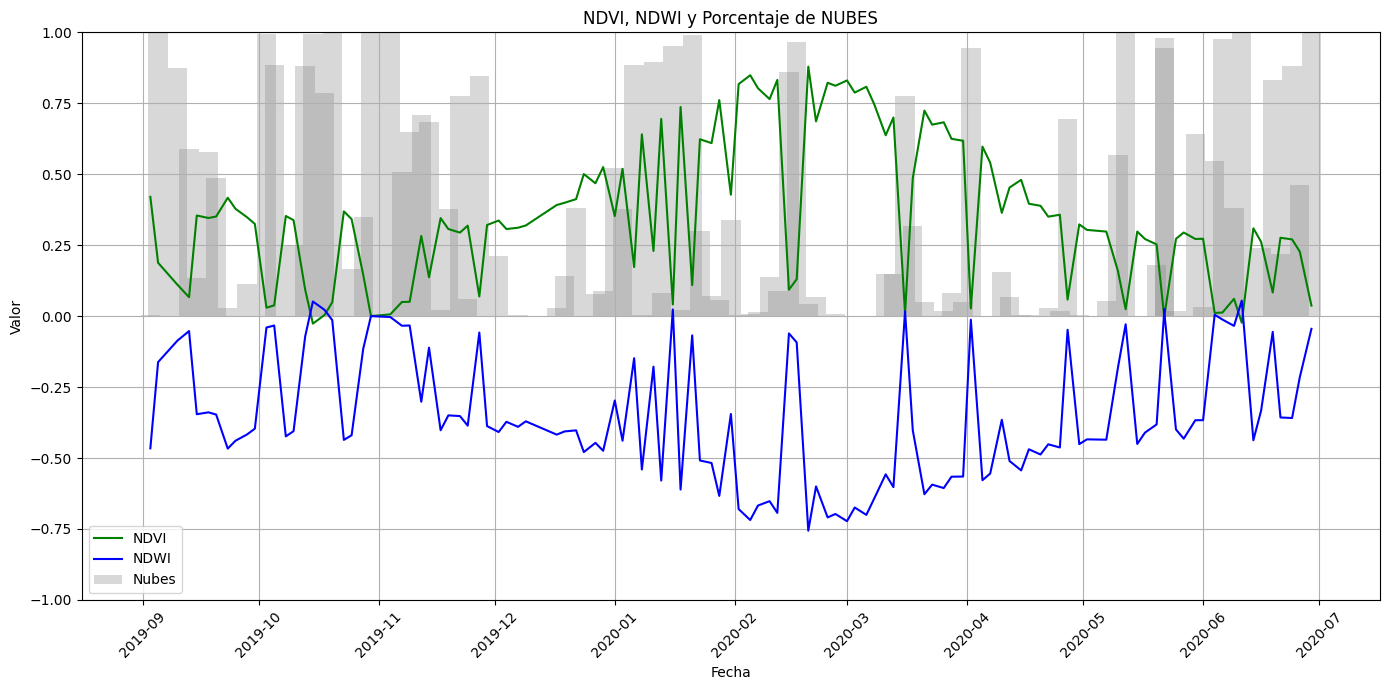

/tmp/ipython-input-1503025672.py:150: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt_peak = datetime.utcfromtimestamp(peak_time_millis / 1000)



Procesando período e1: 2020-01-11 a 2020-01-31
Descargando imagen seleccionada para e1 (2020_01_18)
Descargado: tile_0_0_e1_2020_01_18.tif

Procesando período e2: 2020-02-10 a 2020-03-01
Descargando imagen seleccionada para e2 (2020_02_25)
Descargado: tile_0_0_e2_2020_02_25.tif

Procesando período e3: 2020-03-11 a 2020-04-05
Descargando imagen seleccionada para e3 (2020_03_23)
Descargado: tile_0_0_e3_2020_03_23.tif

Descarga completa para todas las ventanas fenológicas.
/content/drive/MyDrive/data_teg/images_rs_brazil/rs_2020/1920_RS_tiles/1920_4308409_Formigueiro_tiles/tile_3_1.geojson
Posible tamaño a 10m: (933, 857)
Posible tamaño a 20m: (466, 429)

DataFrame exported to: /content/drive/MyDrive/data_teg/images_rs_brazil/rs_2020/1920_RS_tiles/1920_4308409_Formigueiro_tiles/tile_3_1/tile_3_1_stats.csv


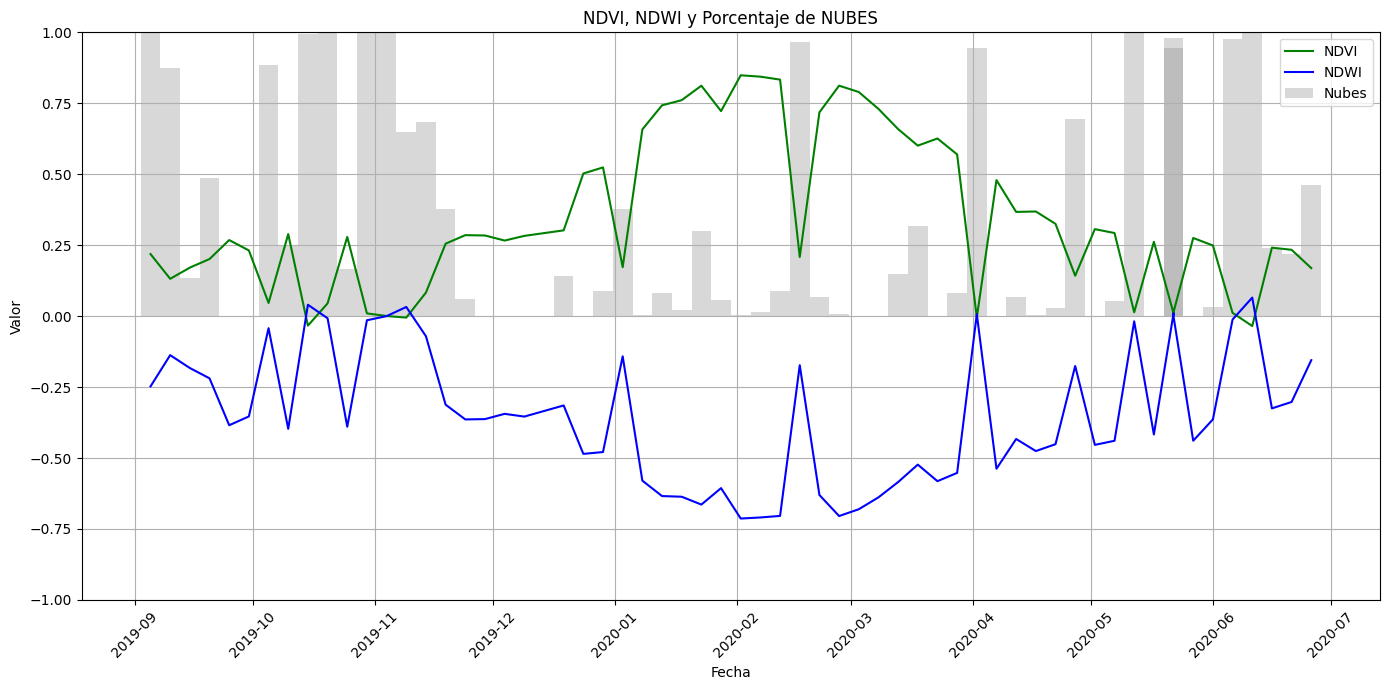

/tmp/ipython-input-1503025672.py:150: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt_peak = datetime.utcfromtimestamp(peak_time_millis / 1000)



Procesando período e1: 2019-12-24 a 2020-01-13
Descargando imagen seleccionada para e1 (2020_01_08)
Descargado: tile_3_1_e1_2020_01_08.tif

Procesando período e2: 2020-01-23 a 2020-02-12
Descargando imagen seleccionada para e2 (2020_02_02)
Descargado: tile_3_1_e2_2020_02_02.tif

Procesando período e3: 2020-02-22 a 2020-03-18
Descargando imagen seleccionada para e3 (2020_03_08)
Descargado: tile_3_1_e3_2020_03_08.tif

Descarga completa para todas las ventanas fenológicas.


In [ ]:
for geojson_path in files:
    print(os.path.join(folder, geojson_path))
    process_geojson_all(os.path.join(folder, geojson_path))